In [8]:
data_dir = './'

In [9]:
%ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 0429-B5BF です

 C:\Users\flare\time-series-analysis-with-Python\jena のディレクトリ

2021/03/25  16:13    <DIR>          .
2021/03/25  16:13    <DIR>          ..
2021/03/25  13:52    <DIR>          .ipynb_checkpoints
2021/03/24  10:56    <DIR>          1.csv
2021/03/24  10:51        43,153,572 2.csv
2021/03/24  10:57    <DIR>          jena_climate_2009_2016.csv
2021/03/24  10:44        13,565,642 jena_climate_2009_2016.csv.zip
2021/03/25  16:13            53,950 keras.ipynb
2021/03/25  12:34            70,629 Untitled.ipynb
2021/03/25  14:08            76,271 Untitled1.ipynb
               5 個のファイル          56,920,064 バイト
               5 個のディレクトリ  119,716,933,632 バイトの空き領域


In [10]:
import os

In [11]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [12]:
f = open('2.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [13]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

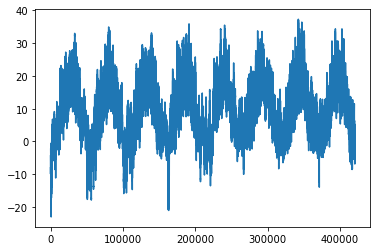

In [14]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

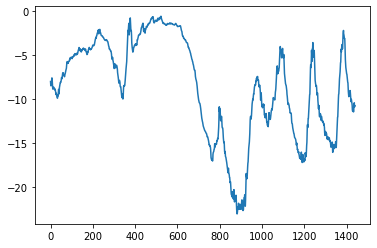

In [15]:
plt.plot(range(1440), temp[:1440])

データの正規化

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

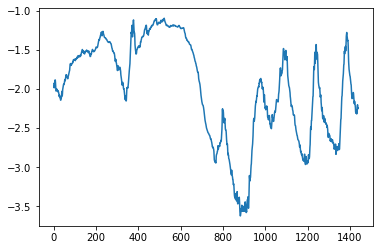

In [17]:
temp = float_data[:, 1]
plt.plot(range(1440), temp[:1440])

In [18]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [28]:
print(train_gen)

<generator object generator at 0x000002A1A0FD00B0>


In [20]:
np.mean(np.abs(preds - targets))

NameError: name 'preds' is not defined

0.2897359729905486


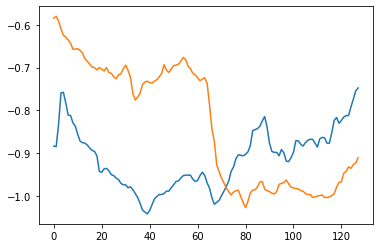

In [65]:
g_preds = []
g_targets = []

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    plt.plot(preds)
    plt.plot(targets)

evaluate_naive_method()

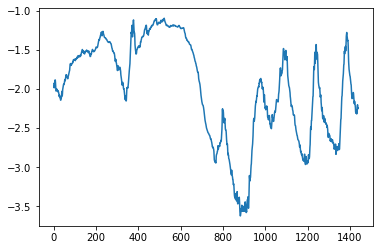

In [66]:
plt.plot(range(1440), temp[:1440])

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 20s 40ms/step - loss: 2.1266 - val_loss: 0.7009
Epoch 2/20
500/500 [==============================] - 24s 48ms/step - loss: 0.5964 - val_loss: 0.4012
Epoch 3/20
500/500 [==============================] - 23s 47ms/step - loss: 0.3394 - val_loss: 0.3156
Epoch 4/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2821 - val_loss: 0.3429
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2614 - val_loss: 0.3125
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2511 - val_loss: 0.3106
Epoch 7/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2429 - val_loss: 0.3171 ETA: 0s - loss: 
Epoch 8/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2372 - val_loss: 0.3434
Epoch 9/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2313 - val_loss: 0.3491
Epoch 10/20
500/500 [==============================] - 22s 44ms/s

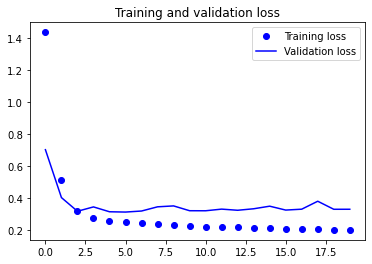

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
print(float_data)

[[ 0.90014748 -1.93135845 -1.98211036 ... -0.72950452 -0.78067973
  -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    ... -0.93124017 -0.88794488
  -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 ... -1.27614304 -1.26122763
  -0.05330633]
 ...
 [ 1.28927851 -1.38236094 -1.46721307 ... -0.69696652 -0.67341457
   0.45008097]
 [ 1.28809932 -1.50323076 -1.58672285 ... -0.43015486 -0.60476487
   0.57246412]
 [ 1.28927851 -1.56987861 -1.65150386 ... -0.5993525  -0.690577
   0.10024989]]


In [43]:
print(history.history)

{'loss': [1.4360711574554443, 0.5086778402328491, 0.3159829080104828, 0.2737225890159607, 0.2571945786476135, 0.24782703816890717, 0.24003340303897858, 0.2357497662305832, 0.22913268208503723, 0.2245190441608429, 0.2201353907585144, 0.2184205949306488, 0.21436303853988647, 0.21338526904582977, 0.20935982465744019, 0.20753362774848938, 0.2047988921403885, 0.20333877205848694, 0.20044639706611633, 0.1988624483346939], 'val_loss': [0.7009372711181641, 0.4011809527873993, 0.31563130021095276, 0.3428550958633423, 0.3124959468841553, 0.31061655282974243, 0.3171335458755493, 0.34343692660331726, 0.3491344749927521, 0.3190056085586548, 0.3187086880207062, 0.32902881503105164, 0.32184576988220215, 0.33122310042381287, 0.34740114212036133, 0.3230467438697815, 0.32862982153892517, 0.3783630430698395, 0.32803836464881897, 0.3281753659248352]}


In [47]:
print(float_data)

[[ 0.90014748 -1.93135845 -1.98211036 ... -0.72950452 -0.78067973
  -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    ... -0.93124017 -0.88794488
  -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 ... -1.27614304 -1.26122763
  -0.05330633]
 ...
 [ 1.28927851 -1.38236094 -1.46721307 ... -0.69696652 -0.67341457
   0.45008097]
 [ 1.28809932 -1.50323076 -1.58672285 ... -0.43015486 -0.60476487
   0.57246412]
 [ 1.28927851 -1.56987861 -1.65150386 ... -0.5993525  -0.690577
   0.10024989]]


In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 110s 213ms/step - loss: 0.3107 - val_loss: 0.2740
Epoch 2/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2860 - val_loss: 0.2652
Epoch 3/20
500/500 [==============================] - 120s 240ms/step - loss: 0.2806 - val_loss: 0.2723
Epoch 4/20
500/500 [==============================] - 120s 240ms/step - loss: 0.2779 - val_loss: 0.2615
Epoch 5/20
500/500 [==============================] - 130s 259ms/step - loss: 0.2659 - val_loss: 0.2665
Epoch 6/20
500/500 [==============================] - 124s 249ms/step - loss: 0.2636 - val_loss: 0.2646
Epoch 7/20
500/500 [==============================] - 116s 233ms/step - loss: 0.2590 - val_loss: 0.2600
Epoch 8/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2532 - val_loss: 0.2634
Epoch 9/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2508 - val_loss: 0.2720
Epoch 10/20
500/500 [==============================] - 136s 272m

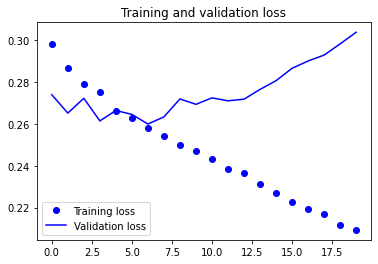

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

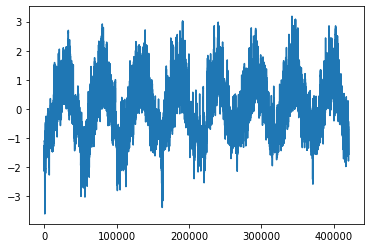

In [61]:
plt.plot(float_data[1:,1])